In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.default_device = 'cuda'
    torch.cuda.set_device(0)
else:
    torch.default_device = 'cpu'

In [4]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:19<00:00, 506284.18it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 133084.70it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1168899.38it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2731258.60it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
batch_size = 100

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([100, 1, 28, 28])
Shape of y: torch.Size([100]) torch.int64


In [6]:
# 网络参数
image_size=28
input_shape = (image_size, image_size, 1)
batch_size = 100
kernel_size = 3
filters = 16
num_latents = 32
classes_per_latent = 10 # 这里假设隐变量是num_latents维、classes_per_latent元随机变量
epochs = 30
shape = 0

In [16]:
eps = torch.finfo(torch.float32).eps
class GumbelSoftmax(nn.Module):
  def __init__(self) -> None:
      super().__init__()
      self.softmax=nn.Softmax()

  def forward(self,x):
    epsilon = torch.rand(x.size()).to(device)
    epsilon = -torch.log(epsilon+eps)
    epsilon = -torch.log(epsilon+eps)
    outputs=x+epsilon
    outputs = self.softmax(outputs)
    return outputs


In [17]:
class encoder(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
     super().__init__(*args, **kwargs)
     self.con1= nn.Conv2d(in_channels=1,
                          out_channels=32,
                kernel_size=(3,3),
                          stride=2,
                          )
     self.con2= nn.Conv2d(in_channels=32,out_channels=64,
                kernel_size=(3,3),
                          stride=2,
                          )
     self.flatten =nn.Flatten()
     self.linear = nn.Linear(2304,32)
     self.relu=nn.ReLU()
     self.dense = nn.Linear(32,num_latents * classes_per_latent)
     self.reshape = nn.Unflatten(1,unflattened_size=[num_latents,classes_per_latent])
     self.gumbel_softmax = GumbelSoftmax()
  def forward(self,x):
    x=self.con1(x)
    x=self.relu(x)
    x=self.con2(x)
    x=self.relu(x)
    x=self.flatten(x)
    x=self.linear(x)
    x=self.relu(x)
    logits=self.dense(x)
    logits=self.reshape(logits)
    z_sample = self.gumbel_softmax(logits)
    return logits,z_sample

In [18]:
class decoder(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(num_latents * classes_per_latent,32)
    self.relu=nn.ReLU()
    self.linear2=nn.Linear(32,64*7*7)
    self.reshape =nn.Unflatten(1,unflattened_size=[64,7,7])
    self.con1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                               kernel_size=3, stride=2,
                               padding=1, output_padding=1)
    self.con2 = nn.ConvTranspose2d(in_channels=64, out_channels=32,
                               kernel_size=3, stride=2,
                               padding=1, output_padding=1)
    self.con3 = nn.ConvTranspose2d(in_channels=32, out_channels=1,
                               kernel_size=3, stride=1,
                               padding=1)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x=self.flatten(x)
    x=self.linear(x)
    x=self.relu(x)
    x=self.linear2(x)
    x=self.relu(x)
    x=self.reshape(x)
    x=self.con1(x)
    x=self.relu(x)
    x=self.con2(x)
    x=self.relu(x)
    x=self.con3(x)
    x=self.sigmoid(x)
    return x


In [40]:
class Vae_gs(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
     super().__init__(*args, **kwargs)
     self.encoder = encoder()
     self.decoder =decoder()
  def forward(self,x):
    logits,z_sample = self.encoder(x)
    x_out = self.decoder(z_sample)
    return logits,x_out
  def predict(self,x):
        return self.decoder(x)

In [41]:
model = Vae_gs()
model.to(device)

Vae_gs(
  (encoder): encoder(
    (con1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (con2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=2304, out_features=32, bias=True)
    (relu): ReLU()
    (dense): Linear(in_features=32, out_features=320, bias=True)
    (reshape): Unflatten(dim=1, unflattened_size=[32, 10])
    (gumbel_softmax): GumbelSoftmax(
      (softmax): Softmax(dim=None)
    )
  )
  (decoder): decoder(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=320, out_features=32, bias=True)
    (relu): ReLU()
    (linear2): Linear(in_features=32, out_features=3136, bias=True)
    (reshape): Unflatten(dim=1, unflattened_size=[64, 7, 7])
    (con1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (con2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
   

In [42]:
import torch.nn.functional as F
def loss_fn(x_in,x_out,logits):
  xent_loss = F.binary_cross_entropy(x_out, x_in, reduction='none')
  xent_loss = xent_loss.sum(dim=(1, 2, 3))  # 对通道和空间维度求和
# KL散度损失 (假设均匀分布先验)
  p = F.softmax(logits, dim=-1)
  p = torch.clamp(p, 1e-7, 1. - 1e-7)
  kl_loss = (p * torch.log(p)).sum(dim=(1,2))  # 对类别求和，得到各空间位置的熵
  # 总VAE损失
  vae_loss = (xent_loss + kl_loss).mean()
  return vae_loss

In [43]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X=X.to(device)
        logits,pred = model(X)
        loss = loss_fn(X, pred,logits)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [44]:
optimizer = torch.optim.RMSprop(model.parameters())
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 399.350464  [  100/60000]


/tmp/ipykernel_1603/4116011650.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = self.softmax(outputs)


loss: 138.483353  [10100/60000]
loss: 152.018402  [20100/60000]
loss: 134.899017  [30100/60000]
loss: 131.205673  [40100/60000]
loss: 119.046188  [50100/60000]
Epoch 2
-------------------------------
loss: 128.412201  [  100/60000]
loss: 136.444748  [10100/60000]
loss: 153.770477  [20100/60000]
loss: 134.302368  [30100/60000]
loss: 130.002823  [40100/60000]
loss: 118.297966  [50100/60000]
Epoch 3
-------------------------------
loss: 127.311523  [  100/60000]
loss: 136.122208  [10100/60000]
loss: 152.068527  [20100/60000]
loss: 133.851013  [30100/60000]
loss: 129.741867  [40100/60000]
loss: 118.381195  [50100/60000]
Epoch 4
-------------------------------
loss: 127.182701  [  100/60000]
loss: 135.865265  [10100/60000]
loss: 148.537216  [20100/60000]
loss: 134.013367  [30100/60000]
loss: 129.547180  [40100/60000]
loss: 118.429077  [50100/60000]
Epoch 5
-------------------------------
loss: 126.946892  [  100/60000]
loss: 135.777496  [10100/60000]
loss: 149.518494  [20100/60000]
loss: 13

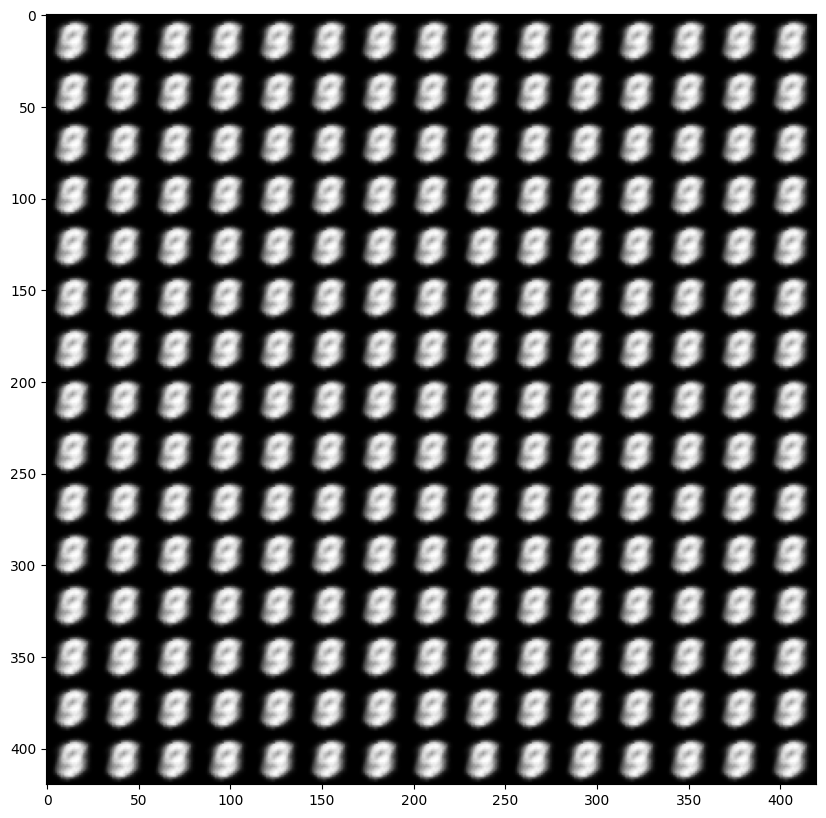

In [51]:
import numpy as np
import matplotlib.pyplot as plt
n = 15  # figure with 15x15 digits
digit_size = 28
figure = torch.zeros((digit_size * n, digit_size * n)).to(device)

for i in range(n):
    for j in range(n):
        z_sample = torch.zeros((1, num_latents, classes_per_latent)).to(device)
        for iz in range(num_latents):
            jz = np.random.choice(classes_per_latent)
            z_sample[0, iz, jz] = 1
        x_decoded = model.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure.cpu().detach().numpy(), cmap='Greys_r')
plt.show()